# Introduction to Qibo

### What is Qibo?
Qibo is an **open-source** full stack API for quantum simulation and quantum hardware
control and calibration.

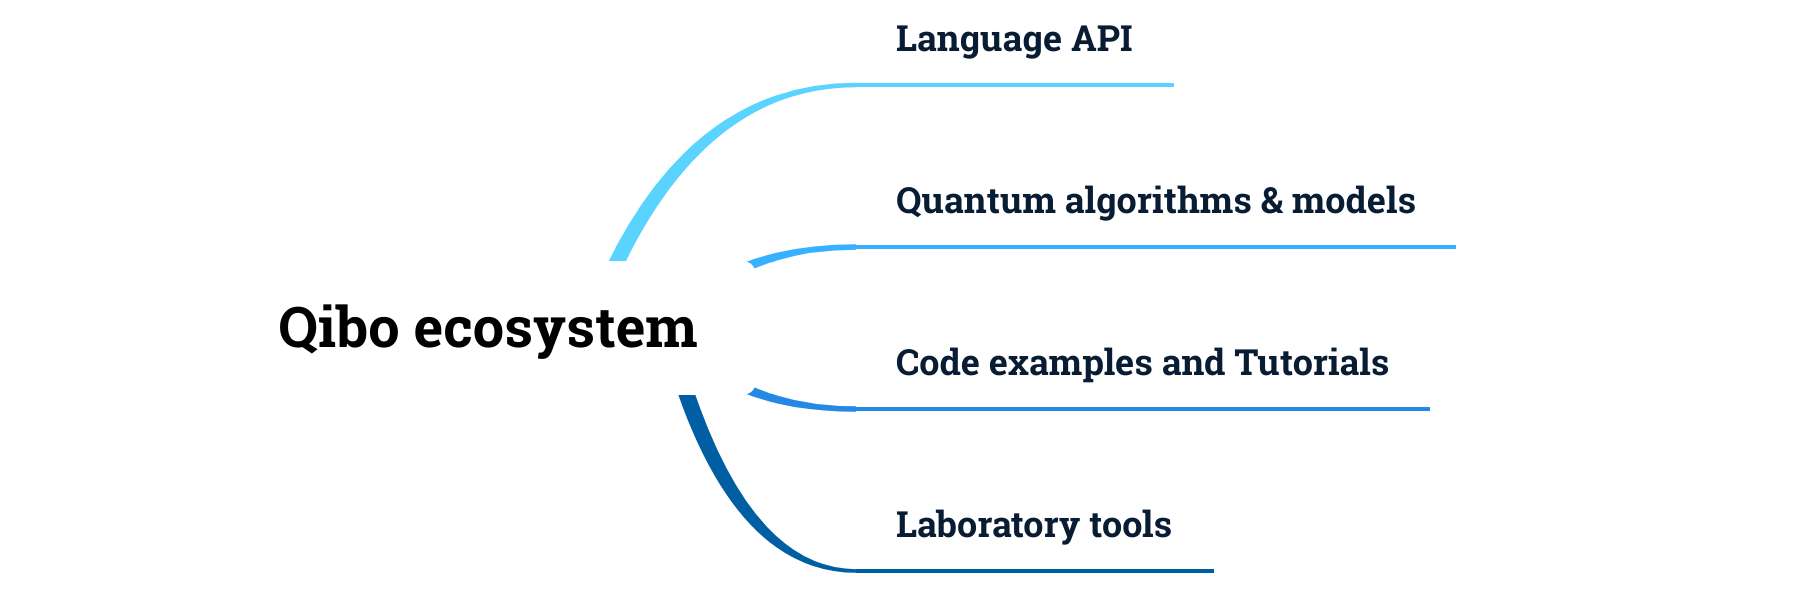

### Goals of this tutorial

* Demonstrate the basic usage Qibo as a quantum circuit simulator.
* Provide examples on a subset of features of Qibo (including a few hints for the exercise that follows).
* Illustrate the importance of hardware acceleration (including GPU) for quantum simulation in practice.

## Qibo installation

The easiest way to install Qibo is through pip:

In [ ]:
!pip install qibo

It is also possible to install Qibo from [source](https://qibo.readthedocs.io/en/stable/getting-started/installation.html#installing-from-source) or using [conda](https://qibo.readthedocs.io/en/stable/getting-started/installation.html#installing-with-conda).
For more information check out the [documentation](https://qibo.readthedocs.io/en/stable/getting-started/installation.html).

## Basic imports

In [ ]:
import time
import numpy as np

# for plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams["font.size"] = 16

In [ ]:
def plot(state):
    """Auxiliary function to visualize qubit on Bloch sphere"""
    # Convert to polar form:
    r = np.abs(state)
    theta = 2 * np.arccos(r[0] / np.sqrt(np.sum(r ** 2)))
    phi = np.angle(state)
    phi = phi[1] - phi[0]

    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    plt.axis("off")
    ax.view_init(15, 0)

    # Sphere and axes
    phis = np.linspace(0, 2 * np.pi, 100)
    ax.plot(np.cos(phis), np.sin(phis), color="black", linewidth=2.0, linestyle="--")
    ax.plot(np.cos(phis), np.sin(phis), zdir="x", color="black", linewidth=2.0)
    ax.plot(np.zeros(100), np.linspace(-1, 1, 100), color="black", linewidth=1.0)
    ax.plot(np.zeros(100), np.linspace(-1, 1, 100), zdir="y", color="black", linewidth=1.0)
    ax.set_aspect('equal', adjustable='box')

    # Bloch sphere axes labels
    ax.text(0, -0.08, 1.15, r"$|0 \rangle $")
    ax.text(0, -0.08, -1.3, r"$|1 \rangle $")
    
    ax.text(0, 0.10, -0.5, "x")
    ax.text(0, 1.2, 0, "y")

    # Define Bloch sphere point
    scat = ax.scatter(x, y, z, color="red", s=50, marker="o")
    # Define Bloch sphere line
    rs = np.linspace(0, 1, 100)
    line, = ax.plot(rs * x, rs * y, rs * z, color="red", linewidth=2.0)

In [ ]:
import qibo
qibo.__version__

qibo.set_backend("numpy") # TODO: Remove this

## Build your first Quantum Circuit using Qibo

Lets start from a simple quantum circuit containing 1 qubit:

In [ ]:
from qibo import gates
from qibo.models import Circuit

nqubits = 1
circuit = Circuit(nqubits)

By the default the initial state of the qubit is assumend to be $\left | 0 \right \rangle $.
Here is a visual representation of this state on the Bloch sphere.

In [ ]:
result = circuit()
plot(result.state())

Let's modify this state by adding some gates in the circuit. For example, a Hadamard gate $H$, creates the superposition $(\left | 0 \right \rangle + \left | 1 \right \rangle )/\sqrt{2}$:

In [ ]:
circuit = Circuit(1)
circuit.add(gates.H(0))

result = circuit()
result

We can also get the state in the computational basis as an array

In [ ]:
result.state()

and represent it in the Bloch sphere

In [ ]:
plot(result.state())

Let's try to add a rotations

In [ ]:
circuit = Circuit(1)
circuit.add(gates.H(0))
circuit.add(gates.RZ(0, theta=np.pi / 3))

result = circuit()
plot(result.state())

## Measurement gate

In a real Quantum Device we **do not** have access to the full state vector when executing a Quantum Circuit.

We can only retrieve information from the qubit by perfoming measurements.

In Qibo it is possibile to simulate measurements by adding measurement gates at the end of the circuit [`gates.M`](https://qibo.readthedocs.io/en/stable/api-reference/qibo.html#measurement-m).

Let's try this on the circuit with the Hadamard gate

In [ ]:
circuit = Circuit(1)
circuit.add(gates.H(0)) # apply H on qubit 0
circuit.add(gates.M(0)) # measure qubit 0

Now when simulating the circuit we must also pass the number of `shots`, which corresponds to the number of times that we measure the circuit.

In [ ]:
result = circuit(nshots=100)

Since we have asked for 50 shots, we can read the 50 samples.

In [ ]:
result.samples()

We can also access the frequencies, which can be easily plotted in an histogram. 

In [ ]:
frequencies = result.frequencies()
frequencies

Note that even when we measure, in simulation we can still access the final state vector

In [ ]:
result

In [ ]:
result.state()

## Multiqubit Circuits

Circuits can of course have more than one qubits. The number of qubits is passed when creating the circuit.

In [ ]:
circuit = Circuit(5)
# add a Hadamard gate to all qubits
for q in range(5):
    circuit.add(gates.H(q))
# add some CNOT gates
circuit.add(gates.CNOT(0, 1))
circuit.add(gates.CNOT(2, 3))
circuit.add(gates.CNOT(0, 4))

To check what the circuit looks like we can call the draw method:

In [ ]:
print(circuit.draw())

We can also print a summary of the circuit

In [ ]:
print(circuit.summary())

or its OpenQASM representation

In [ ]:
print(circuit.to_qasm())

The `circuit.add` method accepts iterators so we can create the same circuit in less lines

In [ ]:
circuit = Circuit(5)
# add a Hadamard gate to all qubits
circuit.add(gates.H(q) for q in range(5))
# add some CZ gates
circuit.add(gates.CNOT(0, 1))
circuit.add(gates.CNOT(2, 3))
circuit.add(gates.CNOT(0, 4))

print(circuit.draw())

Let's add some measurements

In [ ]:
circuit.add(gates.M(q) for q in range(5))

print(circuit.draw())

execute the circuit

In [ ]:
result = circuit(nshots=10000)
result

and look at the measured shots and corresponding frequencies

In [ ]:
result.samples()

In [ ]:
result.frequencies()

## Measurement Registers

Measurement gates can act on more than one qubits and can be used to group the qubits to registers. This is useful for several quantum algorithms.

In [ ]:
circuit = Circuit(3)
circuit.add(gates.RX(0, theta=0.3))
circuit.add(gates.RX(1, theta=0.5))
circuit.add(gates.H(2))
# split measurements to two registers
circuit.add(gates.M(0, 1, register_name="a"))
circuit.add(gates.M(2, register_name="b"))

Now if we execute the circuit

In [ ]:
result = circuit(nshots=1000)
result

we can obtain the measurements on each register seperately

In [ ]:
result.samples(registers=True)

and the same for frequencies

In [ ]:
result.frequencies(registers=True)

## Controlled Gates

*useful for the exercise*

Another useful feature of Qibo when constructing circuit is the ability to control any gate to an arbitrary number of qubits

In [ ]:
circuit = Circuit(4)
circuit.add(gates.H(q) for q in range(4))
circuit.add(gates.Z(3).controlled_by(0, 1, 2))
circuit.add(gates.RX(2, theta=0.5).controlled_by(1, 3))

print(circuit.draw())

Gates that are controlled on many qubits are applied by indexing the state and not by constructing the whole $2^n\times 2^n $ matrix representation of the gate, to improve performance and memory requirements

In [ ]:
%%time
nqubits = 15
circuit = Circuit(nqubits)
circuit.add(gates.X(nqubits - 1).controlled_by(*range(nqubits - 1)))
result = circuit()

In [ ]:
%%time
nqubits = 15
matrix = np.eye(2 ** nqubits, dtype="complex128")
matrix[-2:, -2:] = np.array([[0, 1], [1, 0]])
circuit = Circuit(nqubits)
circuit.add(gates.Unitary(matrix, *range(nqubits)))
result = circuit()

## Quantum Fourier Transform (QFT)

One of the most famous models in Quantum Computing is the Quantum Fourier Transform. It is used in a large variety of quantum algorithms including the Shor's algorithm for integer factorization. It is the quantum counterpart of the classical discrete Fourier transform:

$$ y_k = \sum_{i=0}^{N-1} e^{\frac{2 \pi i k_j}{N}} x_k $$

and can be implemented through the following circuit:

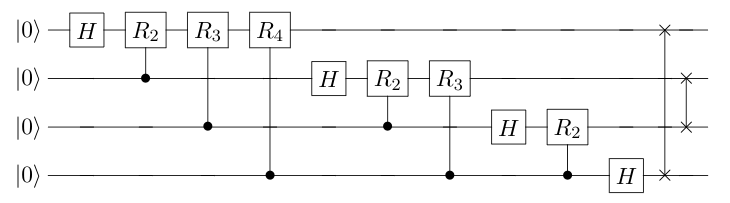



where $R_i$ corresponds to the following gate:

$$ R_i = \begin{pmatrix}
    1 & 0 \\
0 & e^{i \pi/2  \theta_i} 
\end{pmatrix}$$

This model is precoded in Qibo and can be easily imported by the user through the class `models.QFT`.


In [ ]:
from qibo.models import QFT

qft = QFT(nqubits=4)
print(qft.draw())

Note that the QFT model created this way is just a circuit similar to the ones we were using above

In [ ]:
type(qft)

Let's execute the QFT circuit with the default initial state $\left | 0000\right \rangle $

In [ ]:
result = qft()
result

Let's repeat the execution with a random initial state

In [ ]:
initial_state = np.random.random(16) + 1j * np.random.random(16)
initial_state = initial_state / np.sqrt(np.sum(np.abs(initial_state) ** 2))

final_state = qft(initial_state=initial_state).state()

We can confirm the result by comparing with the classical FT equation given above

In [ ]:
dimension = 2 ** qft.nqubits
exponent = np.outer(np.arange(dimension), np.arange(dimension))
cft_matrix = np.exp(2 * np.pi * 1j * exponent / dimension) / np.sqrt(dimension)

In [ ]:
target_state = cft_matrix @ initial_state
np.testing.assert_allclose(final_state, target_state)

It is also possible to get the full unitary matrix implemented by the QFT circuit

In [ ]:
qft_matrix = qft.unitary()
np.testing.assert_allclose(qft_matrix, cft_matrix)

## QFT as a subroutine

*useful for the exercise*

QFT is a commonly used subroutine in many quantum algorithms, such as Shor's. To simplify the process of coding such algorithms, Qibo provides a method for inserting the QFT circuit, or any circuit, to another circuit acting on more qubits. This can be done using the `circuit.on_qubits()` method

In [ ]:
qft = QFT(4)
qft.on_qubits(2, 4, 6, 8)

In [ ]:
circuit = Circuit(8)
circuit.add(qft.on_qubits(*range(4)))
circuit.add(gates.CZ(q, q + 4) for q in range(4))
circuit.add(qft.on_qubits(*range(4, 8)))

print(circuit.draw())

## Hardware acceleration matters

We were able to simulate all the circuits of the above examples almost instantaneously because they had very few qubits. However the simulation complexity increases exponentially with the number of qubits, because describing a $n$-qubit system requires storing and manipulating the state vector consisting of $2^n$ complex numbers.

An easy way to demonstrate this scaling is by measuring the execution time of simulating a circuit, for example the QFT

In [ ]:
execution_times = []
for nqubits in range(10, 21):
    qft = QFT(nqubits)
    start_time = time.time()
    result = qft()
    execution_times.append(time.time() - start_time)
    print(f"nqubits: {nqubits}  -  {execution_times[-1]}sec")

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(range(10, 21), execution_times, "-o")
plt.xlabel("Number of qubits")
plt.ylabel("Execution time (sec)")
plt.show()

### Qibo backends

Qibo provides backends for quantum simulation on classical hardware and quantum hardware management and control. In the image below we present a schematic view of the currently supported backends.

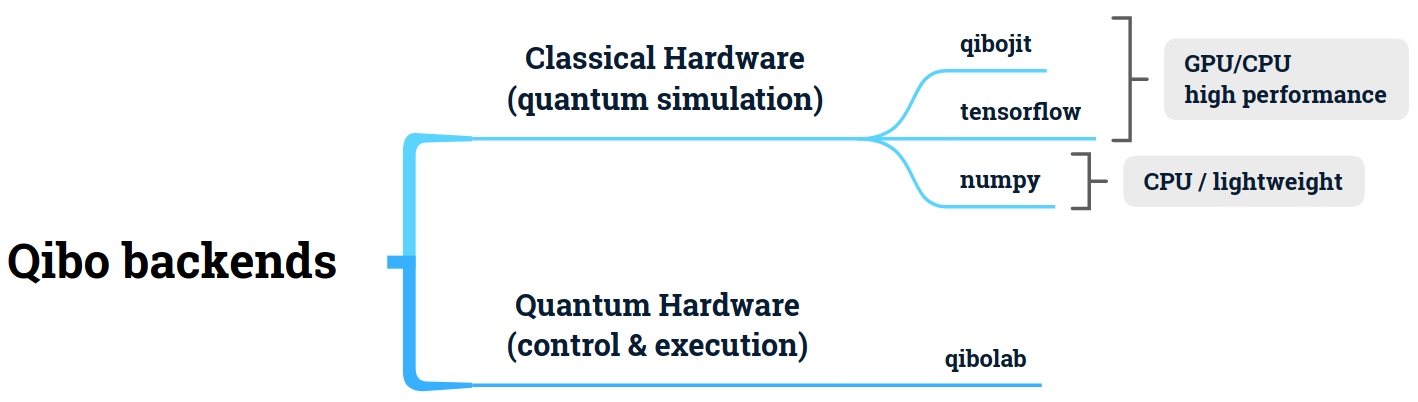

[qibojit](https://github.com/qiboteam/qibojit) is a high performance backend for qibo, aiming to accelerate the simulation of quantum circuits. While it is still a state vector simulator suffering from the exponential complexity, it has several features that make it faster compared to the basic numpy-based simulator we have been using so far:

1. In-place updates of the state vector while applying gates, to avoid copies of the large object.
2. Takes advantage of multi-threading CPU technologies and GPUs.
3. Kernels that apply gates are compiled just-in-time providing C++ performance.

We can install qibojit via pip

In [ ]:
!pip install qibojit

This will provide the base library which supports CPU execution only, based on [numba](https://numba.pydata.org/).

Qibojit can be activated using

In [ ]:
qibo.set_backend("qibojit", platform="numba")

Note that the very first time this command is executed, it will take a few seconds because it is compiling the kernel. 
This only happens once after installing the library.

We can test qibojit's performance by repeating the previous QFT benchmarks.

In [ ]:
nqubits = 20
qft = QFT(nqubits)

start_time = time.time()
result = qft()
execution_time = time.time() - start_time
print(f"nqubits: {nqubits}  -  {execution_time}sec")

## Accelerating further with GPU

Qibojit GPU support is enabled automatically when one installs [CuPy](https://cupy.dev/) and optionally [cuQuantum Python](https://docs.nvidia.com/cuda/cuquantum/index.html). *Note that this requires a GPU with CUDA support and proper driver setup.*

If we install cuQuantum we will automatically get cupy since it is a dependency

In [ ]:
!pip install cuquantum-python-cu11

We can then enable the corresponding Qibo backend as above

In [ ]:
qibo.set_backend("qibojit", platform="cuquantum")

and repeat the QFT benchmark

In [ ]:
nqubits = 25
qft = QFT(nqubits)

start_time = time.time()
result = qft()
execution_time = time.time() - start_time
print(f"nqubits: {nqubits}  -  {execution_time}sec")

## Additional features

Qibo provides many other features to assist and simplify the development of quantum algorithms. Some of the features not covered in this tutorial are the following:

* Density matrix simulation
* Noise models and simulation of noisy circuits with and without density matrices
* A collection of pre-coded variational models (VQE, QAOA, etc.) as well as optimization methods
* Simulation of unitary time evolution with optional acceleration using the Trotter decomposition of the evolution operator
* Simulation of adiabatic evolution and scheduling optimization

More information about Qibo can be found in the [documentation](https://qibo.readthedocs.io/en/stable/) pages, including a list of basic and advanced [examples](https://qibo.readthedocs.io/en/stable/code-examples/index.html), as well as several [applications](https://qibo.readthedocs.io/en/stable/code-examples/applications.html) on recent research.

#### You are also welcome to interact with us and potentially contribute to the project on [GitHub](https://github.com/qiboteam/qibo).